Program that takes in an hdf5 file with 3d array of simulation and outputs the radial profile. Then attempts to fit it onto the analytic radial profile.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from scipy.optimize import minimize

Function takes in path for hdf5 file and outputs a 3d array with all the densities:

In [2]:
# function takes in a path and outputs a 3d array of the density profile.

def file_to_density(path_name):
    hf = h5py.File(path_name, 'r')
    psi_real = np.array(hf['psiRe'])
    psi_im = np.array(hf['psiIm'])
    psi_real2 = psi_real**2
    psi_im2 = psi_im**2
    rho = (psi_real2 + psi_im2)
    return rho

Function rolls the density array so that the core is in the center of the image.

In [3]:
#function takes in a cubic np density array and rolls it so tha the highest point is in the center.
#only to be used for the steady state images

def rho_roll(rho):
    rho_len = rho.shape[0]
    # finding the maximum value's index
    max_ind = np.where(rho == np.amax(rho))
    x_max = max_ind[0][0]
    y_max = max_ind[1][0]
    z_max = max_ind[2][0]
    signed_x_dist_to_cent = int(rho_len / 2) - x_max
    signed_y_dist_to_cent = int(rho_len / 2) - y_max
    signed_z_dist_to_cent = int(rho_len / 2) - z_max
    #moving the core to the center of the cube
    rho_n = np.roll(rho, signed_x_dist_to_cent, axis=0)
    rho_n2 = np.roll(rho_n, signed_y_dist_to_cent, axis=1)
    rho_n3 = np.roll(rho_n2, signed_z_dist_to_cent, axis=2)
    rho = rho_n3
    return rho

A helper function that computes the distance between two 3d points.

In [4]:
# function that calculates distances between two 3d points:

def get_distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2]- b[2])**2)

Function returns a dictionary with the radii as keys and a list of the densities as values.

In [5]:
#function that takes in a 3d array with highest point at the center and calculates
#the density as a function of radius fromt the center of the core. returns as a dictionary with
#distances as keys and a list of the densities as the value.

def radial_density(rho):
    rho_len = rho.shape[0]
    center = int(rho_len / 2)
    radii_den = {}
    for i in range(0, rho_len):
        for j in range(0, rho_len):
            for k in range(0, rho_len):
                dist = get_distance([center, center, center], [i, j, k])
                dens = rho[i][j][k]
                if dist not in radii_den:
                    radii_den[dist] = [dens]
                else:
                    radii_den[dist].append(dens)
    return radii_den

# testing
a = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
b = np.array([[[1, 4], [3, 4]], [[5, 6], [7, 8]]])
dict = radial_density(a)
print(len(dict))
dist = np.fromiter(dict.keys(), dtype=float)
print(dist)


4
[1.73205081 1.41421356 1.         0.        ]


This function takes in a dictionary of radii and densities and returns two numpy arrays, one with radii and the other with average densities.

In [6]:
#function that plots radial density. Takes in a dictionary with densities as keys
# and the densities as values and outputs two np arrays, one with the distances 
# and one with the ---average--- density at that radial distance.

def rad_avg_den(dict):
    dict_len = len(dict)
    dist = np.fromiter(dict.keys(), dtype=float)
    avgs = np.zeros(dict_len)
    for x in range(0, dict_len):
        dens = np.array(dict[dist[x]])
        avg = np.mean(dens)
        avgs[x] = avg
    return dist * (20/128), avgs
# testing
res = rad_avg_den(dict)
print(res[0])
print(res[1])

[0.27063294 0.22097087 0.15625    0.        ]
[1.         3.33333333 5.66666667 8.        ]


Function returns two numpy arrays, one with the radial positions, and the other with all the densities, even the ones with the doubled up radial positions.

In [7]:
# function that takes in dictionary and prints two np arrays, one with the points
# and another with the corresponding densities, including doubles.

def rad_den(dict):
    dict_len = len(dict)
    dist_list = np.fromiter(dict.keys(), dtype=float)
    dist = []
    dens = []
    for x in range(0, dict_len):
        curr_dist = dist_list[x]
        list_len = len(dict[dist_list[x]])
        for i in range(0, list_len):
            dist.append(curr_dist)
            dens.append(dict[dist_list[x]][i])
    dist = np.asarray(dist)
    dens = np.asarray(dens)
    return dist * (20/128), dens

In [8]:
# from path to distance and average density arrays
def file_to_rad_avg_den(path):
    rho = file_to_density(path)
    rho = rho_roll(rho)
    rad_den = radial_density(rho)
    return rad_avg_den(rad_den)

In [9]:
# from path to distance and unaveraged density arrays
def file_to_rad_den(path):
    rho = file_to_density(path)
    rho = rho_roll(rho)
    radial_den = radial_density(rho)
    return rad_den(radial_den)

Testing all the functions to see if they work:

In [ ]:
#testing the file to density function
path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128/snap0300.h5'
res = file_to_rad_avg_den(path)
res2 = file_to_rad_den(path)

In [ ]:
print(len(res[0]))
print(10e4)

In [ ]:
fig_path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128'
fig_name = 'pic300'
plt.scatter(res[0], res[1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(10.5))
plt.xlim(10**(-0.5), 10**(2.2))
plt.savefig(fig_path + "/" + fig_name)
plt.clf()

In [10]:
#file to picture
def file_to_pic(path_to_dir, fig_num, f_str):
    res = file_to_rad_avg_den(path_to_dir + '/snap' + fig_num  + '.h5')
    plt.scatter(res[0], res[1])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel('Density (Msun / (kpc)^3)')
    plt.title('Radial Distance vs. Density: f = ' + f_str)
    plt.ylim(10**4, 10**(10.5))
    plt.xlim(10**(-1), 10**(2.2))
    plt.savefig(path_to_dir + "/" + f_str + 'pic' + fig_num)
    plt.clf()

In [ ]:
#testing
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128', '0350', 'Inf')
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1L20T4n400r128', '0350', '1')
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f2L20T4n400r128', '0350', '2')
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f4L20T4n400r128', '0350', '4')


Function fitting

In [11]:
test_path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1L20T4n400r128/snap0350.h5'
sample_data = file_to_rad_avg_den(test_path)
print(sample_data[0])

[17.32050808 17.2307694  17.14198519 ...  0.22097087  0.15625
  0.        ]


In [12]:
#cuts off a distance array such that it only has elements < a certain length

def dist_cutoff(dist, dist_lim):
    distance = []
    for x in dist:
        if (x < dist_lim):
            distance.append(x)
    return np.asarray(distance)

In [13]:
#cuts off a density array at a given number of elements
#not in place

def dens_cutoff(dens, n_elements):
    densities = np.zeros(n_elements)
    for i in range(0, n_elements):
        densities[i] = dens[i]
    return densities

In [14]:
#analytic profile of the core

def an_prof(r, rc):
    rho = (1.9*10**7 / (rc**4))
    term = (1 + 0.091*(r/rc)**2)**-8
    return rho * term

In [15]:
#X2 function

def X2_fun(rc, dist, dens, dist_lim):
    r = dist_cutoff(dist, dist_lim)
    densities = dens_cutoff(dens, len(r))
    X2 = (((an_prof(r, rc)) - densities)**2)
    indices = [0, len(X2)-1]
    return X2[indices].sum()

      fun: 19280789950.309177
 hess_inv: array([[8.58416344e-18]])
      jac: array([3.4739164e+16])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 219
      nit: 1
     njev: 69
   status: 2
  success: False
        x: array([0.08945693])


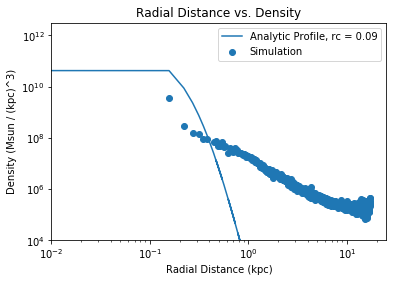

In [26]:
#radial-density fitting function
#params are two nparrays
#analytic radial profile function

def fit_profile(dist, dens, dist_lim):
    dist1 = np.sort(dist)
    dens1 = (-1)*(np.sort(dens*(-1)))
    params = (dist1, dens1, dist_lim)
    x0 = np.asarray(3)
    result = minimize(X2_fun, x0, args = params)
    return result

test_result = fit_profile(sample_data[0], sample_data[1], 10**(-1.1))
print(test_result)

#testing
rc = test_result.x[0]
dist_lim = 0.65
r = sample_data[0]
densities = sample_data[1]
plt.scatter(r, densities)
plt.plot(r, an_prof(r, rc))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))
textstr = 'rc = ' + "%.2f" % rc
plt.legend(['Analytic Profile, rc = ' + "%.2f" % rc,'Simulation'])
plt.show()

In [42]:
def file_to_pic_curve_fit(path, file, dist_lim):
    arrs = file_to_rad_avg_den(path + '/' + file)
    dist = arrs[0]
    dens = arrs[1]
    dist1 = np.sort(dist)
    dens1 = (-1)*(np.sort(dens*(-1)))
    res = fit_profile(dist1, dens1, dist_lim)
    rc = res.x[0]
    plt.scatter(dist1, dens1)
    plt.plot(dist1, an_prof(dist1, rc))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel('Density (Msun / (kpc)^3)')
    plt.title('Radial Distance vs. Density')
    plt.ylim(10**4, 10**(12.5))
    plt.xlim(10**(-2), 10**(1.4))
    textstr = 'rc = ' + "%.2f" % rc
    plt.legend(['Analytic Profile, rc = ' + "%.2f" % rc,'Simulation'])
    plt.savefig(path + '/pic' + file + '.png')
    

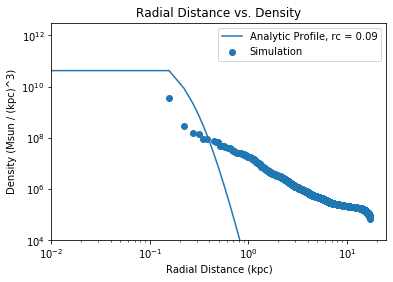

In [43]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1L20T4n400r128', 'snap0350.h5', .1)

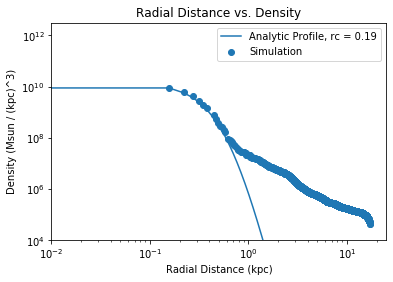

In [44]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128', 'snap0350.h5', .65)

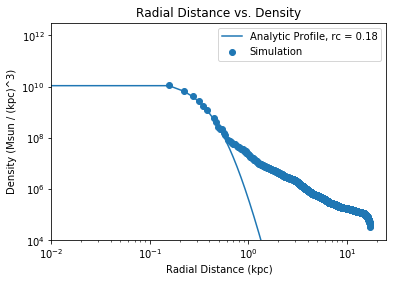

In [45]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f2L20T4n400r128', 'snap0350.h5', 0.65)

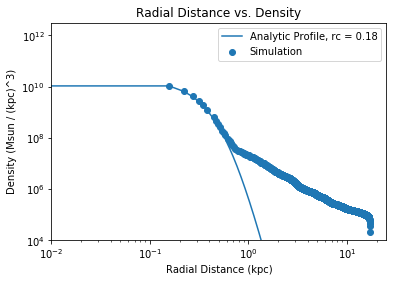

In [46]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f4L20T4n400r128', 'snap0350.h5', 0.65)

In [1]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1.5L20T4n400r128', 'snap0350.h5', 0.65)

NameError: name 'file_to_pic_curve_fit' is not defined